# Jason Huffman - Regis University - MSDS 692 Project

## Summary of Project

This project was performed as a requirement for the Regis University MSDS program.

The goal of this project was to execute an ongoing project from DrivenData.org with the intent of predicting whether individuals received the H1N1 and seasonal flu vaccines based on responses from the National 2009 H1N1 Flu Survey. This survey collected 35 variables on respondents including demographic information and opinions concerning H1N1 as well as information about whether the respondent received either the H1N1 or seasonal flu vaccine; the project can be found here: https://www.drivendata.org/competitions/66/flu-shot-learning/. While the data for this project was a bit dated, the COVID-19 pandemic has made information from the survey relevant again. The survey could potentially be used to identify populations that have historically been reluctant to receive flu type vaccines in order to better target advertising and information campaigns, which could lead to higher vaccination rates once a COVID-19 vaccine is released.

## Import Functions and Data

The data for this project originated from a survey conducted in 2009 by the Center for Disease Control and Prevention (CDC).  The CDC maintains the data on their website as a .dat file, they also provide an R script to translate the .dat file into a CSV file.  As part of their competition page, DrivenData provided a cleaned version of the CDC data split into test and training datasets.  I primarily utilized the dataset off DrivenData's website to create models so that I would have the correct formatting and test split for contest submission.  However, DrivenData removed some information such as individual state data and obscured other information such as region and employment information.  Therefore, I used the data directly from the CDC's website in order to create some visualizations.

I primarily used the scikit-learn toolbox to process data and create models.  This library contained a variety of useful functions for machine learning.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import multilabel_confusion_matrix
from scipy.stats import uniform
from skopt import BayesSearchCV
import matplotlib.pyplot as plt

training_set_features = pd.read_csv("https://raw.githubusercontent.com/jhuffm/Huffman_MSDS-692_Project/master/data/training_set_features.csv", index_col = 'respondent_id')
training_set_labels = pd.read_csv("https://raw.githubusercontent.com/jhuffm/Huffman_MSDS-692_Project/master/data/training_set_labels.csv", index_col = 'respondent_id')
test_set_features = pd.read_csv("https://raw.githubusercontent.com/jhuffm/Huffman_MSDS-692_Project/master/data/test_set_features.csv", index_col = 'respondent_id')
submission_format = pd.read_csv("https://raw.githubusercontent.com/jhuffm/Huffman_MSDS-692_Project/master/data/submission_format.csv", index_col = 'respondent_id')

import warnings
warnings.filterwarnings('ignore')

## Exploratory Data Analysis

Once the datasets were imported, I needed to examine the contents of each dataframe.  For all the binary variables in the datasets a '0' indicates 'No' and a '1' indicates 'Yes'.  A few things were apparent from a quick examination of the data; DrivenData split the total CDC dataset into two even datasets for training and testing, also there were many null values including some in every column in the training dataset.  Additionally, it was evident that almost all the variables were categorical with only a few categories.  Finally, the value_counts() function showed us that the seasonal vaccine data was relatively evenly split between those that received the vaccine and those that did not; however, the H1N1 training data was more lopsided with only about 21% of those surveyed having received the H1N1 vaccine.

In [2]:
display(training_set_features.head())
display(training_set_labels.head())
display(test_set_features.head())
display(training_set_features.info())
display(training_set_features.describe())
display(training_set_labels['h1n1_vaccine'].value_counts())
display(training_set_labels['seasonal_vaccine'].value_counts())

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
respondent_id,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,...,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb


,h1n1_vaccine,seasonal_vaccine
respondent_id,,
0,0,0
1,0,1
2,0,0
3,0,1
4,0,0


,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
respondent_id,,,,,,,,,,,,,,,,,,,,,
26707,2.0,2.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,"> $75,000",Not Married,Rent,Employed,mlyzmhmf,"MSA, Not Principle City",1.0,0.0,atmlpfrs,hfxkjkmi
26708,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,Below Poverty,Not Married,Rent,Employed,bhuqouqj,Non-MSA,3.0,0.0,atmlpfrs,xqwwgdyp
26709,2.0,2.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,...,"> $75,000",Married,Own,Employed,lrircsnp,Non-MSA,1.0,0.0,nduyfdeo,pvmttkik
26710,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,"<= $75,000, Above Poverty",Married,Own,Not in Labor Force,lrircsnp,"MSA, Not Principle City",1.0,0.0,NaN,NaN
26711,3.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,...,"<= $75,000, Above Poverty",Not Married,Own,Employed,lzgpxyit,Non-MSA,0.0,1.0,fcxhlnwr,mxkfnird


<class 'pandas.core.frame.DataFrame'>
Int64Index: 26707 entries, 0 to 26706
Data columns (total 35 columns):
h1n1_concern                   26615 non-null float64
h1n1_knowledge                 26591 non-null float64
behavioral_antiviral_meds      26636 non-null float64
behavioral_avoidance           26499 non-null float64
behavioral_face_mask           26688 non-null float64
behavioral_wash_hands          26665 non-null float64
behavioral_large_gatherings    26620 non-null float64
behavioral_outside_home        26625 non-null float64
behavioral_touch_face          26579 non-null float64
doctor_recc_h1n1               24547 non-null float64
doctor_recc_seasonal           24547 non-null float64
chronic_med_condition          25736 non-null float64
child_under_6_months           25887 non-null float64
health_worker                  25903 non-null float64
health_insurance               14433 non-null float64
opinion_h1n1_vacc_effective    26316 non-null float64
opinion_h1n1_risk          

None

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,household_adults,household_children
count,26615.000000,26591.000000,26636.000000,26499.000000,26688.000000,26665.000000,26620.00000,26625.000000,26579.000000,24547.000000,...,25903.000000,14433.00000,26316.000000,26319.000000,26312.000000,26245.000000,26193.000000,26170.000000,26458.000000,26458.000000
mean,1.618486,1.262532,0.048844,0.725612,0.068982,0.825614,0.35864,0.337315,0.677264,0.220312,...,0.111918,0.87972,3.850623,2.342566,2.357670,4.025986,2.719162,2.118112,0.886499,0.534583
std,0.910311,0.618149,0.215545,0.446214,0.253429,0.379448,0.47961,0.472802,0.467531,0.414466,...,0.315271,0.32530,1.007436,1.285539,1.362766,1.086565,1.385055,1.332950,0.753422,0.928173
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,1.00000,3.000000,1.000000,1.000000,4.000000,2.000000,1.000000,0.000000,0.000000
50%,2.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.00000,0.000000,1.000000,0.000000,...,0.000000,1.00000,4.000000,2.000000,2.000000,4.000000,2.000000,2.000000,1.000000,0.000000
75%,2.000000,2.000000,0.000000,1.000000,0.000000,1.000000,1.00000,1.000000,1.000000,0.000000,...,0.000000,1.00000,5.000000,4.000000,4.000000,5.000000,4.000000,4.000000,1.000000,1.000000
max,3.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,...,1.000000,1.00000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,3.000000,3.000000


0    21033
1     5674
Name: h1n1_vaccine, dtype: int64

0    14272
1    12435
Name: seasonal_vaccine, dtype: int64

I also wanted to examine the distribution of a number of the variables.  From the below histograms, it was clear that many of the binary variables were heavily lopsided and a majority of responses fell into a single category. 

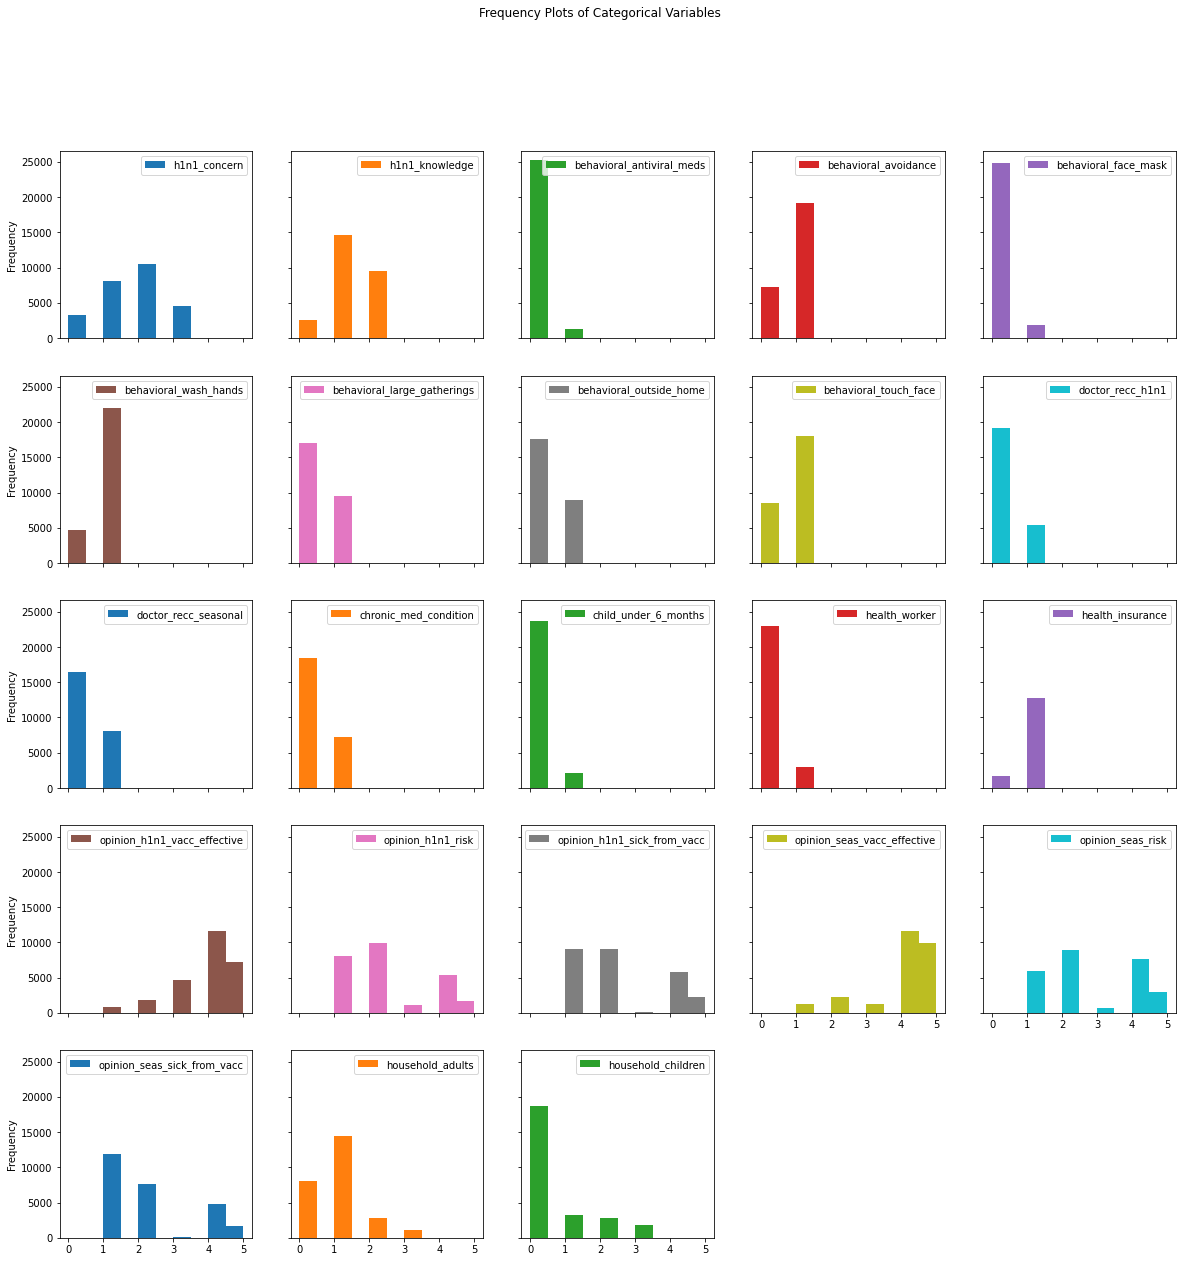

In [3]:
training_set_features.plot(kind = 'hist', subplots=True, layout=(5,5), figsize=(20,20), sharey=True, title = 'Frequency Plots of Categorical Variables')
plt.show()

### Visualizations

One of my goals was to see how location affected the rate of receiving vaccinations; however, the data available on DrivenData's site had the individual state information removed.  Therefore, I pulled the data directly from the CDC and processed it to create the following map.  The code for this map is in the map.py file.

![US Map of Vaccination Rate](map_ratio_of_vaccination.png)

I was surprised to see that there did not appear to be significant regional correlations with the rate of H1N1 vaccinations, though there did appear to be slightly higher vaccination rates in the upper New England area as well as the northern Midwest states.  This map is not perfect though, because every state is not equally represented in the survey meaning fewer responses might have a disproportionate effect on vaccination rate for some states.

In order to better show the ratio of those vaccinated to those not vaccinated, I created a series of bar plots for some of the variables that correlated better with vaccination rate.

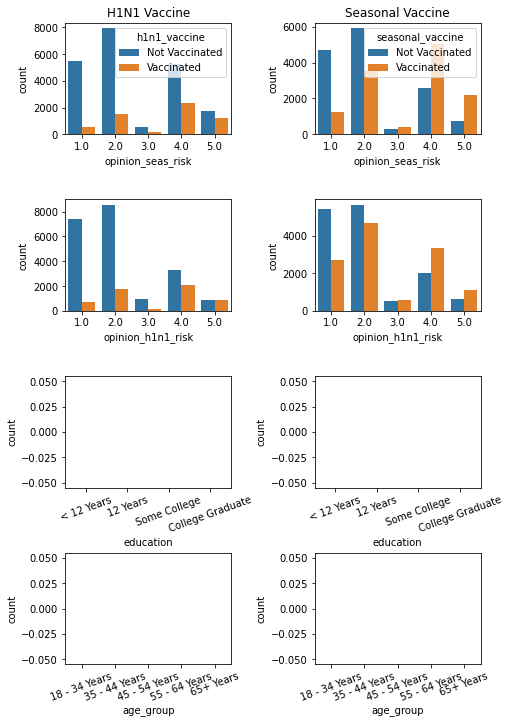

In [17]:
##Visualizations using Seaborn
joined_set = training_set_features.join(training_set_labels)
joined_set['h1n1_vaccine'] = joined_set['h1n1_vaccine'].replace(0, 'Not Vaccinated')
joined_set['h1n1_vaccine'] = joined_set['h1n1_vaccine'].replace(1, 'Vaccinated')
joined_set['seasonal_vaccine'] = joined_set['seasonal_vaccine'].replace(0, 'Not Vaccinated')
joined_set['seasonal_vaccine'] = joined_set['seasonal_vaccine'].replace(1, 'Vaccinated')
order_age = ['18 - 34 Years', '35 - 44 Years', '45 - 54 Years', '55 - 64 Years', '65+ Years']
order_education = ['< 12 Years', '12 Years', 'Some College', 'College Graduate']
order_poverty = ['Below Poverty', '<= $75,000, Above Poverty', '> $75,000']
f, axes = plt.subplots(4,2, sharex = False, sharey=False, figsize = (7,10))

sns.countplot( x = joined_set['opinion_seas_risk'], hue =joined_set['h1n1_vaccine'], data=joined_set, ax = axes[0,0]).set_title('H1N1 Vaccine')
sns.countplot( x = joined_set['opinion_seas_risk'], hue =joined_set['seasonal_vaccine'], data=joined_set, ax = axes[0,1]).set_title('Seasonal Vaccine')

sns.countplot( x = joined_set['opinion_h1n1_risk'], hue =joined_set['h1n1_vaccine'], data=joined_set, ax = axes[1,0]).legend_.remove()
sns.countplot( x = joined_set['opinion_h1n1_risk'], hue =joined_set['seasonal_vaccine'], data=joined_set, ax = axes[1,1]).legend_.remove()

sns.countplot( x = joined_set['education'], hue =joined_set['h1n1_vaccine'], data=joined_set, ax = axes[2,0], order = order_education).set_xticklabels(order_education, rotation=20)
sns.countplot( x = joined_set['education'], hue =joined_set['h1n1_vaccine'], data=joined_set, ax = axes[2,0], order = order_education).legend_.remove()
sns.countplot( x = joined_set['education'], hue =joined_set['seasonal_vaccine'], data=joined_set, ax = axes[2,1], order = order_education).set_xticklabels(order_education, rotation = 20)
sns.countplot( x = joined_set['education'], hue =joined_set['seasonal_vaccine'], data=joined_set, ax = axes[2,1], order = order_education).legend_.remove()

sns.countplot( x = joined_set['age_group'], hue =joined_set['h1n1_vaccine'], data=joined_set, ax = axes[3, 0], order = order_age).set_xticklabels(order_age, rotation=20)
sns.countplot( x = joined_set['age_group'], hue =joined_set['h1n1_vaccine'], data=joined_set, ax = axes[3, 0], order = order_age).legend_.remove()
sns.countplot( x = joined_set['age_group'], hue =joined_set['seasonal_vaccine'], data=joined_set, ax = axes[3,1], order = order_age).set_xticklabels(order_age, rotation=20)
sns.countplot( x = joined_set['age_group'], hue =joined_set['seasonal_vaccine'], data=joined_set, ax = axes[3,1], order = order_age).legend_.remove()

f.tight_layout(pad = 0.5)
plt.show()

## Pre-Process Data

Pre-processing data is a necessary step in any machine learning model.  The data must be uniform and formatted correctly for the models being used. 

### Impute missing values

The first step I took in pre-processing the data was to get rid of missing values in the dataset since many of the modeling techniques do not allow for missing values.  There are a number of methods for handling missing values including removing rows or columns with any missing values or imputing missing values using a statistical constant.  In order to know the best way to proceed, I first determined the number of null values for each variable in the training dataset.

In [5]:
print(training_set_features.isnull().sum())

h1n1_concern                      92
h1n1_knowledge                   116
behavioral_antiviral_meds         71
behavioral_avoidance             208
behavioral_face_mask              19
behavioral_wash_hands             42
behavioral_large_gatherings       87
behavioral_outside_home           82
behavioral_touch_face            128
doctor_recc_h1n1                2160
doctor_recc_seasonal            2160
chronic_med_condition            971
child_under_6_months             820
health_worker                    804
health_insurance               12274
opinion_h1n1_vacc_effective      391
opinion_h1n1_risk                388
opinion_h1n1_sick_from_vacc      395
opinion_seas_vacc_effective      462
opinion_seas_risk                514
opinion_seas_sick_from_vacc      537
age_group                          0
education                       1407
race                               0
sex                                0
income_poverty                  4423
marital_status                  1408
r

From the above output, I was able to see that there are many null values in the training dataset that must be handled prior to modeling.  Due to the range of missing values, I chose a combination of steps to handle them.  First, since three of the columns were missing almost half the entries, I simply removed these columns entirely; these columns were health_insurance, employment_industry, and employment_occupation.  The number of missing values in these columns risked negatively affecting the modeling results.  I then imputed the values of the remaining columns using the mode of the column to fill in the missing values.  I also experimented using mean and KNN imputation techniques but it had little effect on the end result, so out of convenience I used the mode.  This allowed me to impute values prior to numerically encoding the data, and was computationally less expensive than KNN techniques.

In [6]:
training_set_features = training_set_features.drop(columns=['health_insurance', 'employment_industry', 'employment_occupation'])
test_set_features = test_set_features.drop(columns=['health_insurance', 'employment_industry', 'employment_occupation'])

cols = ["h1n1_concern", "h1n1_knowledge", "behavioral_antiviral_meds", "behavioral_avoidance",
        "behavioral_face_mask", "behavioral_wash_hands", "behavioral_large_gatherings", "behavioral_outside_home",
        "behavioral_touch_face", "doctor_recc_h1n1", "doctor_recc_seasonal", "chronic_med_condition",
        "child_under_6_months", "health_worker", "opinion_h1n1_vacc_effective", "opinion_h1n1_risk", 
        "opinion_h1n1_sick_from_vacc", "opinion_seas_vacc_effective", "opinion_seas_risk",
        "opinion_seas_sick_from_vacc", "age_group", "education", "race", "sex", "income_poverty",
        "marital_status", "rent_or_own", "employment_status", "hhs_geo_region", "census_msa", 
        "household_adults", "household_children"]
training_set_features[cols]=training_set_features[cols].fillna(training_set_features.mode().iloc[0])
test_set_features[cols]=test_set_features[cols].fillna(test_set_features.mode().iloc[0])


I then double checked to ensure that there were no longer any null values in the dataset.

In [7]:
print(training_set_features.isnull().sum())

h1n1_concern                   0
h1n1_knowledge                 0
behavioral_antiviral_meds      0
behavioral_avoidance           0
behavioral_face_mask           0
behavioral_wash_hands          0
behavioral_large_gatherings    0
behavioral_outside_home        0
behavioral_touch_face          0
doctor_recc_h1n1               0
doctor_recc_seasonal           0
chronic_med_condition          0
child_under_6_months           0
health_worker                  0
opinion_h1n1_vacc_effective    0
opinion_h1n1_risk              0
opinion_h1n1_sick_from_vacc    0
opinion_seas_vacc_effective    0
opinion_seas_risk              0
opinion_seas_sick_from_vacc    0
age_group                      0
education                      0
race                           0
sex                            0
income_poverty                 0
marital_status                 0
rent_or_own                    0
employment_status              0
hhs_geo_region                 0
census_msa                     0
household_

### Encode Categorical Data

The prediction models can generally only handle numerical data; therefore, all of the categorical object variables had to be numerically encoded.  In this case there were two different types of categorical data: ordinal and nominal.  Ordinal data is categorical data where the order matters, in this dataset the age_group, education, and income_poverty columns were all ordinal data since there was an order from low to high for this data.  The rest of the data was nominal and mostly consisted of binary categories where the order did not matter.

For the ordinal data I specified the order that the data should be in and used the factorize method to convert the object classes to integers.  For the nominal data, I one-hot encoded using Pandas get_dummies method.

I also took the opportunity after encoding the ordinal data to create a correlations chart.  This helped me to visualize the individual correlations between a number of variables and the likelihood to receive either the H1N1 or seasonal flu vaccine.  It also helped determine if any variables were very highly correlated with each other.  If this would have been the case, I would have wanted to remove one of those variables so as to not skew the models.  As it turned out, none of the individual variables were highly correlated with either each other or with the likelihood to receive the H1N1 or seasonal flu vaccine.  this indicated that models were going to be reliant on correlations of combined variables. 

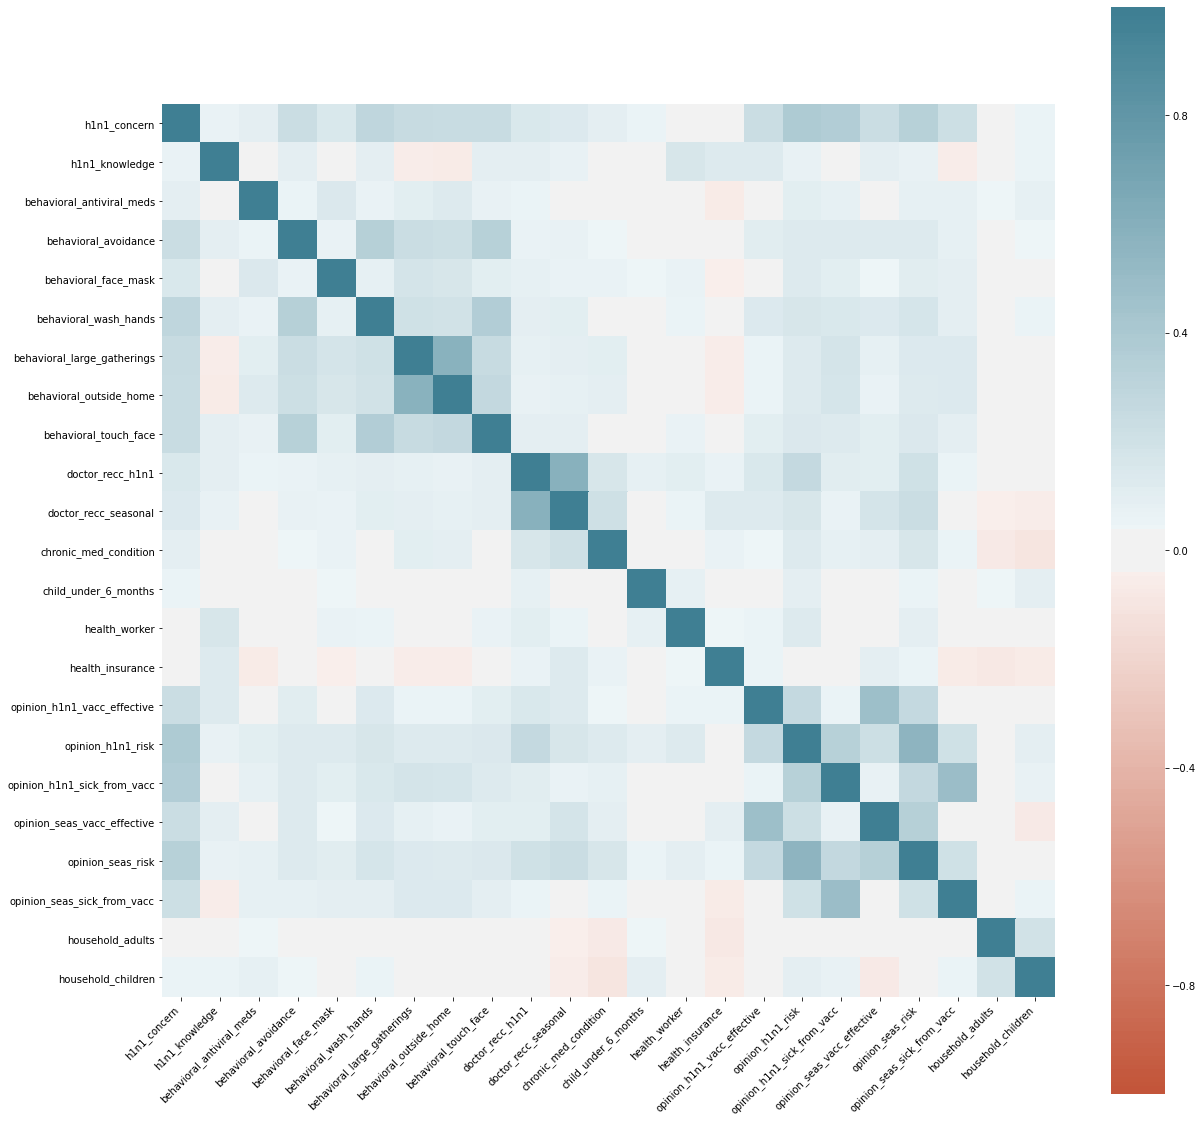

In [8]:
##Encode categorical data
# Ordinal data: age_group, education, income_poverty
# Nominal data: race, sex, marital_status, hhs_geo_region, census_msa

# Using pandas factorize method for ordinal data -- factorizing column data
categories = pd.Categorical(training_set_features['age_group'], categories=order_age, ordered=True)
labels, unique = pd.factorize(categories, sort=True)
training_set_features['age_group'] = labels
categories = pd.Categorical(test_set_features['age_group'], categories=order_age, ordered=True)
labels, unique = pd.factorize(categories, sort=True)
test_set_features['age_group'] = labels

categories = pd.Categorical(training_set_features['education'], categories=order_education, ordered=True)
labels, unique = pd.factorize(categories, sort=True)
training_set_features['education'] = labels
categories = pd.Categorical(test_set_features['education'], categories=order_education, ordered=True)
labels, unique = pd.factorize(categories, sort=True)
test_set_features['education'] = labels

categories = pd.Categorical(training_set_features['income_poverty'], categories=order_poverty, ordered=True)
labels, unique = pd.factorize(categories, sort=True)
training_set_features['income_poverty'] = labels
categories = pd.Categorical(test_set_features['income_poverty'], categories=order_poverty, ordered=True)
labels, unique = pd.factorize(categories, sort=True)
test_set_features['income_poverty'] = labels

###Plot correlations in training set
#print(joined_set.head())
fig, ax = plt.subplots(figsize=(20,20))
corr = joined_set.corr()
htmp = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    ax=ax,
    annot=False
)
htmp.set_xticklabels(
    htmp.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);
plt.show()

##One hot encode nominal categorical variables
training_set_features = pd.get_dummies(training_set_features, columns=['race', 'sex', 'marital_status', 'rent_or_own', 'employment_status', 'hhs_geo_region', 'census_msa'], 
                                       prefix = ['race', 'sex', 'marital_status', 'rent_or_own', 'employment_status', 'hhs_geo_region', 'census_msa'])
test_set_features = pd.get_dummies(test_set_features, columns=['race', 'sex', 'marital_status', 'rent_or_own', 'employment_status', 'hhs_geo_region', 'census_msa'], 
                                       prefix = ['race', 'sex', 'marital_status', 'rent_or_own', 'employment_status', 'hhs_geo_region', 'census_msa'])


### Scale Data

Next, the data had to be scaled, this process normalizes and centers the distance between data points across multiple variables.  Scaling is a necessary step in machine learning as it prevents any one variable from having a disproportionate effect on the model and allows for faster convergence.  I used Scikit Learn's StandardScaler function to scale the data which according to the resource page "standardize[s] features by removing the mean and scaling to unit variance".

In [9]:
##Scale Data
scale = StandardScaler()
scaled_training_features =  scale.fit_transform(training_set_features)
scaled_test_features =  scale.fit_transform(test_set_features)

## Build Prediction Models

### Basic Prediction Models Using Sklearn

The dataset was finally formatted appropriately for use in modeling.  First, I split the training model into a testing and training dataset, this kept the true testing dataset completely separate to be used with the final model.  I initially used six different modeling techniques with default parameters to get a baseline from which to build.  The measurement goal for the DrivenData competition is the ROC AUC score; therefore, I calculated the ROC AUC score for each model.

In [10]:
#Split into test and training set using 80% for training and 20% for testing so that we can keep test_set_labels data outside of the model
X_train, X_test, y_train, y_test = train_test_split(scaled_training_features, training_set_labels, test_size=0.2, random_state=0)

def fit_model(model, X_train, y_train, X_test):
    model.fit(X_train, y_train)
    preds = model.predict_proba(X_test)
    y_preds = pd.DataFrame(
        {
            "h1n1_vaccine": preds[0][:,1],
            "seasonal_vaccine": preds[1][:,1],
        },
        index = y_test.index
    )
    def namestr(obj, namespace):
        return [name for name in namespace if namespace[name] is obj]
    model_name = namestr(model, globals())
    print('The ' + str(model_name)[2:-2] + ' ROC AUC score is ' + str(roc_auc_score(y_test, y_preds)))

Logistic_regression = MultiOutputClassifier(LogisticRegression())  
fit_model(Logistic_regression, X_train, y_train, X_test)

KNN_model = MultiOutputClassifier(KNeighborsClassifier(n_neighbors=300))
fit_model(KNN_model, X_train, y_train, X_test)

Random_forest = MultiOutputClassifier(RandomForestClassifier())
fit_model(Random_forest, X_train, y_train, X_test)

SGD_classifier = MultiOutputClassifier(SGDClassifier(loss="log"))
fit_model(SGD_classifier, X_train, y_train, X_test)

SVC_model = MultiOutputClassifier(SVC(probability = True))
fit_model(SVC_model, X_train, y_train, X_test)

Extra_trees_classifier = MultiOutputClassifier(ExtraTreesClassifier())
fit_model(Extra_trees_classifier, X_train, y_train, X_test)

The Logistic_regression ROC AUC score is 0.8347399891297653
The KNN_model ROC AUC score is 0.8108880047294198
The Random_forest ROC AUC score is 0.8323032543651459
The SGD_classifier ROC AUC score is 0.8136550800256259
The SVC_model ROC AUC score is 0.824354454786338
The Extra_trees_classifier ROC AUC score is 0.8292837079898969


### Parameter Optimization

From the baseline models, I chose two of the best models for which to optimize the hyperparameters.  I decided not to go through this process for each model because it can be very time and resource consuming to optimize model parameters.  The two models I chose to optimize were the Logistic Regression model and the Random Forest Model.

#### Grid Search on Logistic Regression Model

There are not many parameters worth iterating over in the Logistic Regression model; therefore, I chose to use a grid search to perform multiple iterations with different parameters.  A grid search iterates over every possible combination of parameters.  I chose two different parameters with relatively few options for the logistic regression model, so it did not take very long to perform a full grid search.

In [11]:
parameter_grid = {'estimator__C': [0.001,0.01,0.1,1,10,100],
            'estimator__penalty' : ['l1', 'l2']}

Log_regression_grid_optimized_classifier = GridSearchCV(
    estimator =  MultiOutputClassifier(LogisticRegression(solver='saga', max_iter=200)),
    param_grid = parameter_grid,
    scoring = 'roc_auc',
    n_jobs = 2,
    refit = True,
    cv = 5,
    return_train_score = True)

fit_model(Log_regression_grid_optimized_classifier, X_train, y_train, X_test)
cv_results_df = pd.DataFrame(Log_regression_grid_optimized_classifier.cv_results_)
best_row = cv_results_df[cv_results_df["rank_test_score"]==1]
print(best_row)

The Log_regression_grid_optimized_classifier ROC AUC score is 0.8349505845890733
   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
4       0.776918      0.045015         0.006982        0.002092   

  param_estimator__C param_estimator__penalty  \
4                0.1                       l1   

                                              params  split0_test_score  \
4  {'estimator__C': 0.1, 'estimator__penalty': 'l1'}           0.838644   

   split1_test_score  split2_test_score  ...  mean_test_score  std_test_score  \
4           0.840152           0.848554  ...         0.839144         0.00561   

   rank_test_score  split0_train_score  split1_train_score  \
4                1            0.841652            0.841112   

   split2_train_score  split3_train_score  split4_train_score  \
4            0.839077            0.842001            0.843425   

   mean_train_score  std_train_score  
4          0.841453         0.001413  

[1 rows x 22 columns]


#### Bayesian Search on Random Forest Model

The Random Forest model has a lot of hyperparameters that I chose to optimize, making a full grid search inefficient to implement.  I first used a random search method to optimize the parameters, this method randomly picks parameters for each iteration and can be very effective at picking the best parameters without iterating over every possibility.  However, I ended up using a Bayesian approach to parameter optimization because it was more targeted than but had the same advantage as a Random Search approach in that it does not examine every possible combination.

In [12]:
## Random Forest parameter optimization w/ Bayesian Method
n_estimators = [10, 50, 100, 200, 400, 600, 800, 1000, 2000]
max_depth = [10, 20, 30, 40, 60, 80, 100, 1000]
min_samples_split = [2, 5, 10, 20, 50]
min_samples_leaf = [1, 2, 4]
max_features = ['auto', 'log2']
param_grid = {'estimator__n_estimators': n_estimators,
               'estimator__max_depth': max_depth,
               'estimator__min_samples_split': min_samples_split,
               'estimator__min_samples_leaf': min_samples_leaf,
               'estimator__max_features': max_features}

#random_forest_Bayes_optimized_classifier = BayesSearchCV(
#    MultiOutputClassifier(RandomForestClassifier()),
#    param_grid,
#    n_iter = 100,
#    scoring = 'roc_auc',
#    n_jobs = 4,
#    refit = True,
#    cv = 3,
#    random_state = 1,
#    return_train_score = True)

#fit_model(random_forest_Bayes_optimized_classifier, X_train, y_train, X_test)
#print(random_forest_Bayes_optimized_classifier.best_estimator_)

![Random Forest Parameters](random_forest_parameters.PNG)

#### Confusion Matrix

Utilizing the parameters from Bayesian search it was possible to create a confusion matrix.  A confusion matrix allows us to examine the number of true/false positives/negatives.  This is an especially helpful tool for lopsided data or when false positives or negatives can have significant consequences such as with health screening.

In [13]:
random_forest_optim = MultiOutputClassifier(RandomForestClassifier(n_estimators = 2000, max_depth = 20, min_samples_split = 20, min_samples_leaf = 4, max_features= 'auto')) 
classifier = random_forest_optim.fit(X_train, y_train)
cm = multilabel_confusion_matrix(y_test, random_forest_optim.predict(X_test))
print(cm)

[[[4006  166]
  [ 732  438]]

 [[2306  550]
  [ 631 1855]]]


The first confusion matrix shown above is for the H1N1 vaccine prediction and the second is for the flu vaccine prediction.  The bottom left corner of the matrix shows the false negatives and the upper right shows the false positives.  We can see that the model had a larger number of false negatives than false positives for both the H1N1 and flu data.  In this case it is preferable to have false negatives over false positives because it signifies that the model predicted that an individual did not receive the vaccine when in fact they did.  This would lead to an over-targeting of information to a population rather than an under-targeting, which is preferable to get maximum vaccine participation.  

Also, it is important to note that the submission to DrivenData are probabilistic predictions rather than absolute predictions.  This can help to alleviate the impact of false predictions by providing some context as to how confident the model is in a certain decision in the form of a probability.

## Formatting and Completion

### Train Model on Full Dataset

After optimizing parameters, the Random Forest technique provided the best ROC AUC score; therefore, I used the parameters from the Bayesian search to train the model on the full dataset in order to provide more training data than the split set allowed for.  This final trained model was then used to predict the probabilities on the test set.

In [14]:
random_forest_optim.fit(scaled_training_features, training_set_labels)
preds = random_forest_optim.predict_proba(scaled_test_features)

### Format for Submission to DrivenData

Finally, I formatted the probabilities for submission to DrivenData's website.  This competition is not an active prize competition on DrivenData's website but rather is just for experimenting and learning.

In [15]:
#Code copied from DrivenData to ensure correct format for submittal

# Save predictions to submission data frame
submission_format["h1n1_vaccine"] = preds[0][:, 1]
submission_format["seasonal_vaccine"] = preds[1][:, 1]

print(submission_format.head())
submission_format.to_csv('my_submission.csv', index= True)

               h1n1_vaccine  seasonal_vaccine
respondent_id                                
26707              0.133151          0.279084
26708              0.043217          0.044165
26709              0.507975          0.832745
26710              0.538448          0.864287
26711              0.238839          0.423872


DrivenData provides a final ROC AUC on each model submitted.  My final model reached an ROC AUC of 0.8373. 
![Submission Score](submission_score.PNG)

## Going Forward

### Model Refinement

There are a number of things that can be done to further refine the model in an effort to improve its performance.

One way to potentially increase the AUC statistic would be to tune the hyperparameters on all six original models.  I only chose two of the models to tune hyperparameters on but it is possible that one of the other four could yield better results with properly tuned parameters.  Another option would be to allow for more iterations when tuning parameters.  I chose 100 iterations in order to keep the runtime manageable when creating the model.  However, more iterations would mean that more models are attempted which could potentially yield better results.  In addition to more iterations, I could readjust the grid to center around the values reached with the Bayesian method.  This could be beneficial for some of the parameters where the best parameter found was one of the bookend values in the grid, such as for n_estimators.

Another refinement technique would be to reduce the number of variables used to create the model.  This could help eliminate some of the noise in the data that is used to create the model. 

### Applications

While this dataset was based on a 2009 H1N1 vaccine survey, there are likely overlapping conditions that would determine whether populations will receive a COVID-19 vaccine once available.  The information could be used to better target advertising and information campaigns, which could lead to higher vaccination rates once a COVID-19 vaccine is released.


## Resources

